In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

In [2]:
# Load Pima Indians Diabetes Dataset from OpenML
pima = fetch_openml(name='diabetes', version=1, as_frame=True)
df = pima.frame


In [3]:
# Map the target to binary labels
df['class'] = df['class'].map({'tested_negative': 0, 'tested_positive': 1})

# Features and target
X = df.drop('class', axis=1)
y = df['class']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Build a pipeline with imputation, scaling, and classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [5]:
# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose()
pipeline, report_df.head()

(Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                 ('clf', RandomForestClassifier(random_state=42))]),
               precision    recall  f1-score     support
 0              0.785714  0.777778  0.781726   99.000000
 1              0.607143  0.618182  0.612613   55.000000
 accuracy       0.720779  0.720779  0.720779    0.720779
 macro avg      0.696429  0.697980  0.697169  154.000000
 weighted avg   0.721939  0.720779  0.721328  154.000000)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib
import warnings
warnings.filterwarnings('ignore')

In [10]:
class GlucoGuardAI:
    """
    GlucoGard AI - Diabetes Risk Prediction Model
    Built specifically for Rwanda's healthcare environment
    """

    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.models = {}
        self.best_model = None
        self.feature_names = []

    def generate_synthetic_data(self, n_samples=1000):
        """
        Generate synthetic data representative of Rwandan population
        Based on common risk factors for diabetes
        """
        np.random.seed(42)

        # Generate synthetic features
        age = np.random.normal(45, 15, n_samples)
        age = np.clip(age, 18, 80)  # Age between 18-80

        # BMI - higher prevalence of overweight in urban Rwanda
        bmi = np.random.normal(25, 4, n_samples)
        bmi = np.clip(bmi, 16, 45)

        # Weight (kg)
        weight = np.random.normal(70, 12, n_samples)
        weight = np.clip(weight, 45, 120)

        # Height (cm) - typical for Rwandan population
        height = np.random.normal(168, 8, n_samples)
        height = np.clip(height, 150, 190)

        # Blood pressure (systolic)
        systolic_bp = np.random.normal(125, 20, n_samples)
        systolic_bp = np.clip(systolic_bp, 90, 180)

        # Family history (0=No, 1=Yes)
        family_history = np.random.binomial(1, 0.3, n_samples)

        # Physical activity level (0=Low, 1=Moderate, 2=High)
        physical_activity = np.random.choice([0, 1, 2], n_samples, p=[0.4, 0.4, 0.2])

        # Diet quality score (0-10, higher is better)
        diet_quality = np.random.beta(2, 3, n_samples) * 10

        # Urban vs Rural (0=Rural, 1=Urban)
        location = np.random.binomial(1, 0.4, n_samples)  # 40% urban

        # Smoking status (0=No, 1=Yes)
        smoking = np.random.binomial(1, 0.15, n_samples)  # 15% smokers

        # Calculate risk factors for diabetes
        risk_score = (
            (age - 18) * 0.02 +  # Age factor
            (bmi - 18.5) * 0.1 +  # BMI factor
            (systolic_bp - 90) * 0.01 +  # BP factor
            family_history * 0.3 +  # Family history
            (2 - physical_activity) * 0.15 +  # Physical activity (inverse)
            (10 - diet_quality) * 0.02 +  # Diet quality (inverse)
            smoking * 0.2 +  # Smoking
            np.random.normal(0, 0.1, n_samples)  # Random noise
        )

        # Convert risk score to categories
        # 0: Non-diabetic, 1: Low risk, 2: Moderate risk, 3: High risk, 4: Critical risk
        risk_category = np.zeros(n_samples)
        risk_category[risk_score > 0.5] = 1  # Low risk
        risk_category[risk_score > 1.0] = 2  # Moderate risk
        risk_category[risk_score > 1.5] = 3  # High risk
        risk_category[risk_score > 2.0] = 4  # Critical risk

        # Create DataFrame
        data = pd.DataFrame({
            'age': age,
            'bmi': bmi,
            'weight': weight,
            'height': height,
            'systolic_bp': systolic_bp,
            'family_history': family_history,
            'physical_activity': physical_activity,
            'diet_quality': diet_quality,
            'location': location,
            'smoking': smoking,
            'risk_category': risk_category.astype(int)
        })

        return data

    def preprocess_data(self, data):
        """
        Preprocess the data for training
        """
        # Create additional features
        data['bmi_category'] = pd.cut(data['bmi'],
                                     bins=[0, 18.5, 25, 30, 100],
                                     labels=[0, 1, 2, 3])  # Underweight, Normal, Overweight, Obese

        data['age_group'] = pd.cut(data['age'],
                                  bins=[0, 30, 45, 60, 100],
                                  labels=[0, 1, 2, 3])  # Young, Middle-aged, Senior, Elderly

        # Convert categorical variables to numeric
        data['bmi_category'] = data['bmi_category'].astype(int)
        data['age_group'] = data['age_group'].astype(int)

        # Select features for model
        feature_columns = ['age', 'bmi', 'weight', 'height', 'systolic_bp',
                          'family_history', 'physical_activity', 'diet_quality',
                          'location', 'smoking', 'bmi_category', 'age_group']

        X = data[feature_columns]
        y = data['risk_category']

        self.feature_names = feature_columns

        return X, y

    def train_models(self, X, y):
        """
        Train multiple models and select the best one
        """
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Initialize models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'SVM': SVC(probability=True, random_state=42),
            'Neural Network': self.create_neural_network(X_train_scaled.shape[1])
        }

        model_scores = {}

        # Train and evaluate each model
        for name, model in models.items():
            if name == 'Neural Network':
                # Train neural network
                model.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
                         validation_split=0.2, verbose=0)
                y_pred = model.predict(X_test_scaled)
                y_pred_classes = np.argmax(y_pred, axis=1)
                score = accuracy_score(y_test, y_pred_classes)
            else:
                # Train sklearn models
                if name in ['Logistic Regression', 'SVM']:
                    model.fit(X_train_scaled, y_train)
                    y_pred = model.predict(X_test_scaled)
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                score = accuracy_score(y_test, y_pred)

            model_scores[name] = score
            self.models[name] = model

            print(f"{name} Accuracy: {score:.4f}")

        # Select best model
        best_model_name = max(model_scores, key=model_scores.get)
        self.best_model = self.models[best_model_name]

        print(f"\nBest Model: {best_model_name} (Accuracy: {model_scores[best_model_name]:.4f})")

        return X_test, y_test, best_model_name

    def create_neural_network(self, input_dim):
        """
        Create a neural network model for diabetes risk prediction
        """
        model = Sequential([
            Dense(64, activation='relu', input_shape=(input_dim,)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dense(5, activation='softmax')  # 5 risk categories
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

        return model

    def predict_risk(self, patient_data):
        """
        Predict diabetes risk for a single patient
        """
        # Convert to DataFrame if necessary
        if isinstance(patient_data, dict):
            patient_data = pd.DataFrame([patient_data])

        # Preprocess the data
        patient_data['bmi_category'] = pd.cut(patient_data['bmi'],
                                             bins=[0, 18.5, 25, 30, 100],
                                             labels=[0, 1, 2, 3]).astype(int)

        patient_data['age_group'] = pd.cut(patient_data['age'],
                                          bins=[0, 30, 45, 60, 100],
                                          labels=[0, 1, 2, 3]).astype(int)

        # Select features
        X_patient = patient_data[self.feature_names]

        # Scale if needed
        if hasattr(self.best_model, 'predict_proba'):
            if isinstance(self.best_model, (LogisticRegression, SVC)):
                X_patient_scaled = self.scaler.transform(X_patient)
                prediction = self.best_model.predict(X_patient_scaled)[0]
                probabilities = self.best_model.predict_proba(X_patient_scaled)[0]
            else:
                prediction = self.best_model.predict(X_patient)[0]
                probabilities = self.best_model.predict_proba(X_patient)[0]
        else:
            # Neural network
            X_patient_scaled = self.scaler.transform(X_patient)
            probabilities = self.best_model.predict(X_patient_scaled)[0]
            prediction = np.argmax(probabilities)

        # Risk categories
        risk_categories = ['Non-diabetic', 'Low Risk', 'Moderate Risk', 'High Risk', 'Critical Risk']

        return {
            'risk_category': risk_categories[prediction],
            'risk_level': int(prediction),
            'probabilities': {risk_categories[i]: float(prob) for i, prob in enumerate(probabilities)}
        }

    def generate_recommendations(self, risk_level, patient_data):
        """
        Generate personalized recommendations based on risk level
        """
        recommendations = {
            'dietary': [],
            'lifestyle': [],
            'medical': [],
            'monitoring': []
        }

        if risk_level == 0:  # Non-diabetic
            recommendations['dietary'] = [
                "Maintain a balanced diet with plenty of vegetables and fruits",
                "Limit processed foods and sugary drinks",
                "Include whole grains in your meals"
            ]
            recommendations['lifestyle'] = [
                "Continue regular physical activity",
                "Maintain healthy weight",
                "Get adequate sleep (7-9 hours)"
            ]
            recommendations['monitoring'] = [
                "Annual health check-ups",
                "Monitor weight regularly"
            ]

        elif risk_level == 1:  # Low Risk
            recommendations['dietary'] = [
                "Reduce sugar intake and refined carbohydrates",
                "Increase fiber-rich foods",
                "Control portion sizes"
            ]
            recommendations['lifestyle'] = [
                "Exercise at least 30 minutes daily",
                "Maintain healthy BMI (18.5-24.9)",
                "Quit smoking if applicable"
            ]
            recommendations['monitoring'] = [
                "Check blood sugar annually",
                "Monitor blood pressure regularly"
            ]

        elif risk_level == 2:  # Moderate Risk
            recommendations['dietary'] = [
                "Follow a low-glycemic diet",
                "Limit carbohydrates to 45-65% of total calories",
                "Include lean proteins and healthy fats"
            ]
            recommendations['lifestyle'] = [
                "Increase physical activity to 45-60 minutes daily",
                "Weight loss if overweight (5-10% of body weight)",
                "Stress management techniques"
            ]
            recommendations['medical'] = [
                "Consider consultation with a nutritionist",
                "Discuss prevention strategies with healthcare provider"
            ]
            recommendations['monitoring'] = [
                "Blood sugar screening every 6 months",
                "Regular blood pressure monitoring"
            ]

        elif risk_level == 3:  # High Risk
            recommendations['dietary'] = [
                "Strict carbohydrate counting",
                "Mediterranean or DASH diet",
                "Avoid sugary beverages completely"
            ]
            recommendations['lifestyle'] = [
                "Daily exercise program",
                "Structured weight loss program",
                "Sleep hygiene improvement"
            ]
            recommendations['medical'] = [
                "Immediate consultation with healthcare provider",
                "Consider pre-diabetes medication if recommended",
                "Regular monitoring by healthcare team"
            ]
            recommendations['monitoring'] = [
                "Blood sugar testing every 3 months",
                "Monthly weight and BMI tracking"
            ]

        elif risk_level == 4:  # Critical Risk
            recommendations['dietary'] = [
                "Immediate dietary intervention required",
                "Work with registered dietitian",
                "Meal planning and preparation"
            ]
            recommendations['lifestyle'] = [
                "Supervised exercise program",
                "Immediate lifestyle modification",
                "Smoking cessation program if applicable"
            ]
            recommendations['medical'] = [
                "Urgent medical consultation required",
                "Consider immediate intervention",
                "Regular monitoring by healthcare team"
            ]
            recommendations['monitoring'] = [
                "Monthly medical check-ups",
                "Weekly self-monitoring of risk factors"
            ]

        return recommendations

    def visualize_results(self, data, X_test, y_test):
        """
        Create visualizations for model performance and data insights
        """
        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Risk Category Distribution
        risk_categories = ['Non-diabetic', 'Low Risk', 'Moderate Risk', 'High Risk', 'Critical Risk']
        risk_counts = data['risk_category'].value_counts().sort_index()

        axes[0, 0].bar(range(len(risk_counts)), risk_counts.values, color=['green', 'yellow', 'orange', 'red', 'darkred'])
        axes[0, 0].set_title('Distribution of Diabetes Risk Categories')
        axes[0, 0].set_xlabel('Risk Category')
        axes[0, 0].set_ylabel('Number of Patients')
        axes[0, 0].set_xticks(range(len(risk_categories)))
        axes[0, 0].set_xticklabels(risk_categories, rotation=45)

        # 2. BMI vs Age with Risk Categories
        scatter = axes[0, 1].scatter(data['age'], data['bmi'], c=data['risk_category'],
                                    cmap='RdYlGn_r', alpha=0.6)
        axes[0, 1].set_title('BMI vs Age by Risk Category')
        axes[0, 1].set_xlabel('Age')
        axes[0, 1].set_ylabel('BMI')
        plt.colorbar(scatter, ax=axes[0, 1])

        # 3. Feature Importance (if using Random Forest)
        if hasattr(self.best_model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.best_model.feature_importances_
            }).sort_values('importance', ascending=True)

            axes[1, 0].barh(feature_importance['feature'], feature_importance['importance'])
            axes[1, 0].set_title('Feature Importance')
            axes[1, 0].set_xlabel('Importance')

        # 4. Model Performance Metrics
        if hasattr(self.best_model, 'predict'):
            if isinstance(self.best_model, (LogisticRegression, SVC)):
                X_test_scaled = self.scaler.transform(X_test)
                y_pred = self.best_model.predict(X_test_scaled)
            else:
                y_pred = self.best_model.predict(X_test)

            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
            axes[1, 1].set_title('Confusion Matrix')
            axes[1, 1].set_xlabel('Predicted')
            axes[1, 1].set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

    def save_model(self, filepath):
        """
        Save the trained model and scaler
        """
        model_data = {
            'best_model': self.best_model,
            'scaler': self.scaler,
            'feature_names': self.feature_names
        }
        joblib.dump(model_data, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """
        Load a saved model
        """
        model_data = joblib.load(filepath)
        self.best_model = model_data['best_model']
        self.scaler = model_data['scaler']
        self.feature_names = model_data['feature_names']
        print(f"Model loaded from {filepath}")

🏥 GlucoGard AI - Diabetes Risk Prediction System
📊 Generating synthetic patient data...
Generated 1000 patient records

🔄 Preprocessing data...

🤖 Training AI models...
Random Forest Accuracy: 0.7600
Logistic Regression Accuracy: 0.8550
SVM Accuracy: 0.8100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Neural Network Accuracy: 0.8150

Best Model: Logistic Regression (Accuracy: 0.8550)

📈 Generating visualizations...


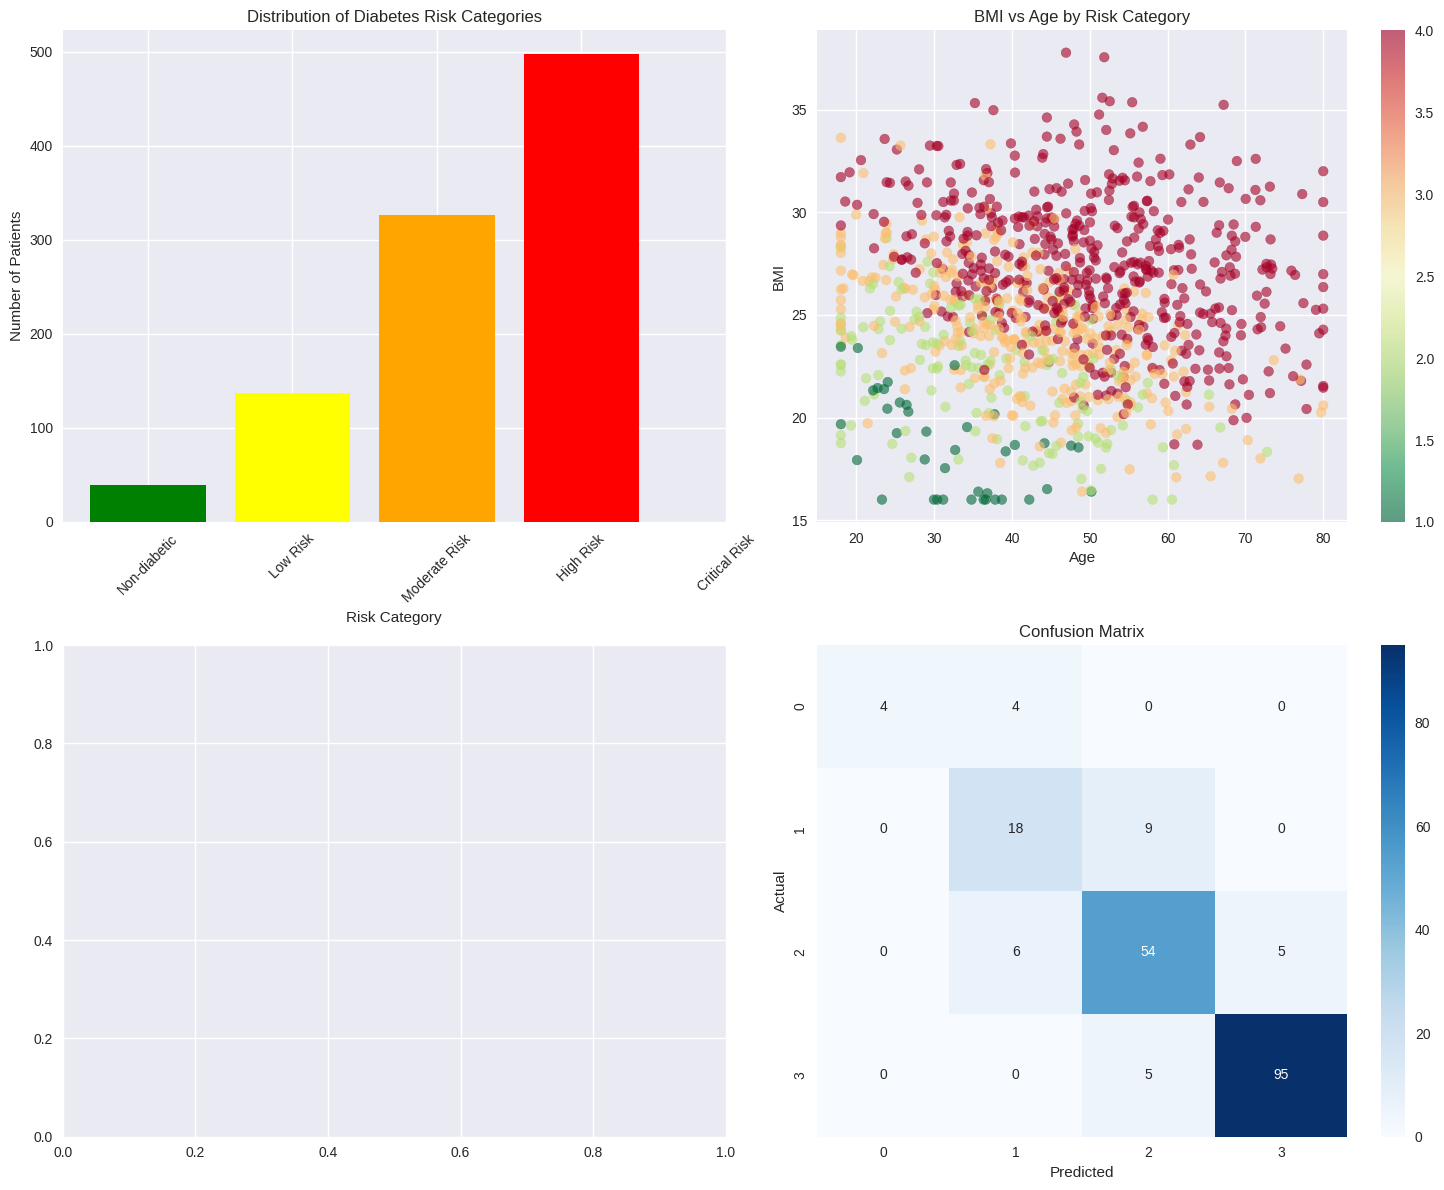


🔮 Example Risk Prediction:
------------------------------
Patient Profile:
  age: 45
  bmi: 28.5
  weight: 75
  height: 165
  systolic_bp: 140
  family_history: 1
  physical_activity: 1
  diet_quality: 6
  location: 1
  smoking: 0

🎯 Risk Assessment: Critical Risk
📊 Risk Level: 4

📋 Risk Probabilities:
  Non-diabetic: 0.00%
  Low Risk: 0.00%
  Moderate Risk: 0.28%
  High Risk: 99.72%

💡 Personalized Recommendations:
------------------------------

Dietary:
  • Immediate dietary intervention required
  • Work with registered dietitian
  • Meal planning and preparation

Lifestyle:
  • Supervised exercise program
  • Immediate lifestyle modification
  • Smoking cessation program if applicable

Medical:
  • Urgent medical consultation required
  • Consider immediate intervention
  • Regular monitoring by healthcare team

Monitoring:
  • Monthly medical check-ups
  • Weekly self-monitoring of risk factors

💾 Saving trained model...
Model saved to glucogard_ai_model.pkl

✅ GlucoGard AI syst

In [11]:
# Example usage and demonstration
def main():
    """
    Main function to demonstrate the GlucoGard AI system
    """
    print("🏥 GlucoGard AI - Diabetes Risk Prediction System")
    print("=" * 50)

    # Initialize the system
    glucogard = GlucoGuardAI()

    # Generate synthetic data
    print("📊 Generating synthetic patient data...")
    data = glucogard.generate_synthetic_data(1000)
    print(f"Generated {len(data)} patient records")

    # Preprocess data
    print("\n🔄 Preprocessing data...")
    X, y = glucogard.preprocess_data(data)

    # Train models
    print("\n🤖 Training AI models...")
    X_test, y_test, best_model_name = glucogard.train_models(X, y)

    # Visualize results
    print("\n📈 Generating visualizations...")
    glucogard.visualize_results(data, X_test, y_test)

    # Example prediction
    print("\n🔮 Example Risk Prediction:")
    print("-" * 30)

    # Sample patient data
    sample_patient = {
        'age': 45,
        'bmi': 28.5,
        'weight': 75,
        'height': 165,
        'systolic_bp': 140,
        'family_history': 1,
        'physical_activity': 1,
        'diet_quality': 6,
        'location': 1,
        'smoking': 0
    }

    print("Patient Profile:")
    for key, value in sample_patient.items():
        print(f"  {key}: {value}")

    # Make prediction
    prediction = glucogard.predict_risk(sample_patient)
    print(f"\n🎯 Risk Assessment: {prediction['risk_category']}")
    print(f"📊 Risk Level: {prediction['risk_level']}")

    print("\n📋 Risk Probabilities:")
    for category, prob in prediction['probabilities'].items():
        print(f"  {category}: {prob:.2%}")

    # Generate recommendations
    recommendations = glucogard.generate_recommendations(prediction['risk_level'], sample_patient)

    print(f"\n💡 Personalized Recommendations:")
    print("-" * 30)

    for category, recs in recommendations.items():
        if recs:
            print(f"\n{category.title()}:")
            for rec in recs:
                print(f"  • {rec}")

    # Save model
    print("\n💾 Saving trained model...")
    glucogard.save_model('glucogard_ai_model.pkl')

    print("\n✅ GlucoGard AI system setup complete!")
    print("🚀 Ready for deployment in Rwanda's healthcare system")

if __name__ == "__main__":
    main()